In [1]:
from openadmet.toolkit.chemoinformatics.data_curation import CSVProcessing
import os
import pandas as pd
import numpy as np
from typing import Optional
from collections import defaultdict
import re

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Curating PXR compound activity data from the Tox21 Study for model training
There are a couple of PXR datasets to start with:  
1. 'AID_1347033_datatable.csv' is the summary data from https://pubchem.ncbi.nlm.nih.gov/bioassay/1347033#section=BioAssay-Type  
2. 'AID_1346982_datatable.csv' is the assay data with replicates from https://pubchem.ncbi.nlm.nih.gov/bioassay/1346982  
3. 'AID_1346977_datatable.csv' is the counter screen assay data with replicates from https://pubchem.ncbi.nlm.nih.gov/bioassay/1346977  

Use the function `process_data` to process the raw data files, i.e. add 'CANONICAL_SMILES' and 'INCHIKEY'.

In [2]:
def process_data(input_files:list, input_path:str, output_path:str, force_process:bool=False):
    '''
    Function to process csv data tables from PubChem by adding CANONICAL_SMILES and INCHIKEY with the CSVProcessing class and outputting the resulting csv file to the "processed" folder.

    You can force reprocess all csv data tables in the "input_data" folder by setting force_process=True
    OR you can process only the csv data tables that have not already been processed, aka have a corresponding csv in the "processed" folder.
    '''
    if force_process:
        for i in input_files:
            df = CSVProcessing.read_csv(os.path.join(input_path, i))
            processor = CSVProcessing()
            data = processor.standardize_smiles_and_convert(data=df)
            data.to_csv(os.path.join(output_path, f"processed_{i[:-4]}.csv"), index=False)
    
    else: # process only input files that have not already been processed
        processed_files = os.listdir(output_path)

        for i in input_files:
            if not any(i in f for f in processed_files):
                df = CSVProcessing.read_csv(os.path.join(input_path, i))
                processor = CSVProcessing()
                data = processor.standardize_smiles_and_convert(data=df)
                data.to_csv(os.path.join(output_path, f"processed_{i[:-4]}.csv"), index=False)


In [3]:
root = os.getcwd()
input_folder = 'input_data'
output_folder = 'processed'
input_path = os.path.join(root, input_folder)
output_path = os.path.join(root, output_folder)

input_files = [file for file in os.listdir(input_path) if '.csv' in file]

process_data(input_files=input_files, input_path=input_path, output_path=output_path)

## Now ingest the processed data files for cleaning
If `/processed` folder includes files from multiple proteins, will need to add some logic to get only the data files for, e.g. PXR

In [4]:
protein = "PXR"

processed_files = os.listdir(output_path)
processed_files

['processed_AID_1346982_datatable.csv',
 'processed_AID_1347033_datatable.csv',
 'processed_AID_1346977_datatable.csv']

In [5]:
data = {}

for i in processed_files:
    df = CSVProcessing.read_csv(os.path.join(output_folder, i))
    data[i] = df

data.keys()

/Users/cynthiaxu/Documents/Coding Projects/OMSF/openadmet-toolkit/openadmet/toolkit/chemoinformatics/data_curation.py:21: DtypeWarning: Columns (129,134,141,169,174,181,209,214,221,249,254,261,289,294,301,329,334,341,369,374,381,409,414,421,449,454,461,489,494,501,529,534,541,569,574,581,609,614,621,649,654,661,689,694,701,729,734,741,769,774,781,809,814,821,849,854,861,889,894,901,929,934,941,969,974,981,1009,1014,1021,1049,1054,1061,1089,1094,1101,1129,1134,1141,1169,1174,1181,1209,1214,1221,1249,1254,1261,1289,1294,1301,1329,1334,1341,1369,1374,1381,1409,1414,1421,1449,1454,1461,1489,1494,1501,1529,1534,1541,1569,1574,1581,1609,1614,1621,1649,1654,1661,1689,1694,1701,1729,1734,1741,1769,1774,1781,1809,1814,1821,1849,1854,1861,1889,1894,1901,1929,1934,1941,1969,1974,1981,2009,2014,2021) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path, sep=sep)
/Users/cynthiaxu/Documents/Coding Projects/OMSF/openadmet-toolkit/openadmet/toolkit/ch

dict_keys(['processed_AID_1346982_datatable.csv', 'processed_AID_1347033_datatable.csv', 'processed_AID_1346977_datatable.csv'])

In [6]:
# Rename the dfs to be more readably distinct
summary_df = data['processed_AID_1347033_datatable.csv']
rep_df = data['processed_AID_1346982_datatable.csv']
counter_rep_df = data['processed_AID_1346977_datatable.csv']

print(f"Number rows in summary data {len(summary_df)}. \n" +
      f"Number rows in replicate data {len(rep_df)}. \n" +
      f"Number rows in counter screen replicate data {len(counter_rep_df)}.")

Number rows in summary data 9478. 
Number rows in replicate data 9478. 
Number rows in counter screen replicate data 9478.


### Clean up the replicate data and merge
1. Get the means and standard deviations for all numeric replicate columns  
2. Calculate pAC50 from potency  
3. Drop columns that have all `NaN`  
4. Select only the newly calculated `mean` and `std` columns AND the `OPENADMET_CANONICAL_SMILES` and `INCHIKEY` columns  
5. Merge the screen replicate and counter screen replicate data

In [7]:
def clean_rep_data(df, type:Optional[str]=None):
    rep_cols = [x for x in df.columns if 'Replicate' in x and np.issubdtype(df[x].dtype, np.number) and 'Activity at' not in x]
    # Remove the activity at X uM columns; these are used data points for fitting the Hill Eqn (i assume)
    grouped_cols = defaultdict(list)

    for col in rep_cols:
        base_name = re.sub(r"-?Replicate_\d+$", "", col)
        grouped_cols[base_name].append(col)

    for base, cols in grouped_cols.items():
        if type:
            mean_col = f"{type}_{base.lower()}_mean"
            std_col = f"{type}_{base.lower()}_std"
        else:
            mean_col = f"{base.lower()}_mean"
            std_col = f"{base.lower()}_std"
        df[mean_col] = df[cols].mean(axis=1)
        df[std_col] = df[cols].std(axis=1)

        # Compute pAC50 only if this is a potency column
        if "potency" in base.lower():
            pac50_mean_col = f"{type}_pAC50_mean" if type else "pAC50_mean"
            pac50_std_col = f"{type}_pAC50_std" if type else "pAC50_std"
            
            df[pac50_mean_col] = -np.log10(df[mean_col] * 10**-6)
            df[pac50_std_col] = -np.log10(df[std_col] * 10**-6)
            
        # Drop mean column if all values are NaN
        if df[mean_col].isna().all():
            df.drop(columns=[mean_col], inplace=True)
        
        # Drop std column if all values are NaN
        if df[std_col].isna().all():
            df.drop(columns=[std_col], inplace=True)
    
    new_cols = [x for x in df.columns if "_mean" in x or "_std" in x]
    select_cols = ["OPENADMET_CANONICAL_SMILES", "INCHIKEY"]+ new_cols

    clean_df = df[select_cols]
    # Average biological replicates by INCHIKEY
    clean_df = (
        df[select_cols]
        .groupby("INCHIKEY", as_index=False)
        .agg({**{col: 'first' for col in ["OPENADMET_CANONICAL_SMILES"]},
            **{col: 'mean' for col in new_cols}})
    )

    return clean_df

In [8]:
clean_rep_df = clean_rep_data(df=rep_df)
clean_counter_df = clean_rep_data(df=counter_rep_df, type='counter')

# merge the screen replicates and counter screen replicates
merged_rep = clean_rep_df.merge(clean_counter_df, on=["INCHIKEY", "OPENADMET_CANONICAL_SMILES"], how="inner")
merged_rep

/Users/cynthiaxu/miniconda3/envs/openadmet/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cynthiaxu/miniconda3/envs/openadmet/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,INCHIKEY,OPENADMET_CANONICAL_SMILES,potency_mean,potency_std,pAC50_mean,pAC50_std,efficacy_mean,efficacy_std,activity_score_mean,activity_score_std,fit_logac50_mean,fit_logac50_std,fit_hillslope_mean,fit_hillslope_std,fit_r2_mean,fit_r2_std,fit_infiniteactivity_mean,fit_infiniteactivity_std,fit_zeroactivity_mean,fit_zeroactivity_std,fit_curveclass_mean,fit_curveclass_std,max_response_mean,max_response_std,counter_potency_mean,counter_potency_std,counter_pAC50_mean,counter_pAC50_std,counter_efficacy_mean,counter_efficacy_std,counter_activity_score_mean,counter_activity_score_std,counter_fit_logac50_mean,counter_fit_logac50_std,counter_fit_hillslope_mean,counter_fit_hillslope_std,counter_fit_r2_mean,counter_fit_r2_std,counter_fit_infiniteactivity_mean,counter_fit_infiniteactivity_std,counter_fit_zeroactivity_mean,counter_fit_zeroactivity_std,counter_fit_curveclass_mean,counter_fit_curveclass_std,counter_max_response_mean,counter_max_response_std
0,AADCDMQTJNYOSS-LBPRGKRZSA-N,CCC1=CC(Cl)=C(OC)C(C(=O)NC[C@@H]2CCCN2CC)=C1O,22.398800,12.904645,4.649775,4.889254,77.737867,19.578699,2.784314,11.531372,-4.725100,0.346410,2.406400,0.000000,0.936033,0.038419,80.849233,21.099331,3.111233,1.948935,1.800000,0.519615,67.612333,12.103475,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-6.091767,2.671298,3.760700,2.068415,0.681167,0.119095,-11.577233,8.946982,4.666667,6.350853,4.000000,0.000000,-13.075133,3.142165
1,AADVZSXPNRLYLV-GKMXPDSGSA-N,O=C(O)[C@@H]1[C@H]2C[C@H]3C4=C(CCN3C[C@@H]2CC[...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,-0.325467,11.166721,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-7.125100,NaN,4.954900,NaN,0.349800,NaN,-0.833233,1.443202,0.166667,0.288675,4.000000,0.000000,-1.097967,4.301904
2,AAEVYOVXGOFMJO-UHFFFAOYSA-N,CSC1=NC(NC(C)C)=NC(NC(C)C)=N1,27.206050,4.063173,4.575278,5.445731,135.825700,37.503774,2.176471,8.946752,-4.581517,0.077349,1.137767,0.158849,0.977767,0.008443,141.809750,41.835031,5.984083,7.369158,2.116667,0.028868,117.485067,31.377143,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,-0.339850,2.323766
3,AAFXQFIGKBLKMC-KQQUZDAGSA-N,O=C(O)/C=C/C1=CC=C(/C=C/C(=O)O)C=C1,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.395167,1.326822,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.423600,NaN,4.954900,NaN,0.540700,NaN,2.666667,4.618802,-0.315467,0.546404,4.000000,0.000000,1.707067,3.720881
4,AAIBYZBZXNWTPP-UHFFFAOYSA-N,OC1CCCCC1C1=CC=CC=C1,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.163700,NaN,3.677200,NaN,0.668200,NaN,5.000000,8.660254,-0.327267,0.566842,4.000000,0.000000,6.354733,7.588835,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.163700,NaN,3.990000,NaN,0.809200,NaN,4.333333,7.505553,0.302133,0.523310,4.000000,0.000000,4.820267,4.465910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7191,ZZXUZKXVROWEIF-UHFFFAOYSA-N,CCC1COC(=O)O1,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-5.563700,1.331353,2.395300,2.227129,0.535033,0.181503,11.556133,13.828718,0.762033,0.284053,4.000000,0.000000,10.487000,9.376703,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-5.013700,NaN,2.720200,NaN,0.784600,NaN,2.333333,4.041452,-0.042800,0.074132,4.000000,0.000000,3.637300,3.743876
7192,ZZYASVWWDLJXIM-UHFFFAOYSA-N,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O,25.095367,5.660528,4.600406,5.247143,71.940100,16.066190,2.372549,9.585324,-4.608433,0.104083,1.836667,0.442144,0.945000,0.036255,72.621667,17.357874,0.681533,1.774350,2.133333,0.057735,57.057133,10.076082,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.906233,1.652583
7193,ZZYSLNWGKKDOML-UHFFFAOYSA-N,CCC1=NN(C)C(C(=O)NCC2=CC=C(C(C)(C)C)C=C2)=C1Cl,22.775700,4.096777,4.642528

### Clean summary data & merge with cleaned replicate data

In [9]:
keep_cols = [
    'INCHIKEY',
    'OPENADMET_CANONICAL_SMILES',
    'PUBCHEM_ACTIVITY_OUTCOME',
    'PUBCHEM_ACTIVITY_SCORE',
    'Agonist Potency (uM)',
    'Agonist Efficacy (%)',
    'Viability Potency (uM)',
    'Viability Efficacy (%)'
]

agg_cols = [
    'PUBCHEM_ACTIVITY_SCORE',
    'Agonist Potency (uM)',
    'Agonist Efficacy (%)',
    'Viability Potency (uM)',
    'Viability Efficacy (%)'
]

clean_summary_df = (
    summary_df[keep_cols]
    .groupby("INCHIKEY", as_index=False)
    .agg(
        {**{col: ['mean', 'std'] for col in agg_cols},
         'OPENADMET_CANONICAL_SMILES': 'first',
         'PUBCHEM_ACTIVITY_OUTCOME': 'first'}
    )
)

clean_summary_df.columns = [
    col[0] if col[0] == 'OPENADMET_CANONICAL_SMILES' or col[0] == 'INCHIKEY' or col[0] == 'PUBCHEM_ACTIVITY_OUTCOME' else f'{col[0]}_{col[1]}'
    for col in clean_summary_df.columns.values
]
clean_summary_df

,INCHIKEY,PUBCHEM_ACTIVITY_SCORE_mean,PUBCHEM_ACTIVITY_SCORE_std,Agonist Potency (uM)_mean,Agonist Potency (uM)_std,Agonist Efficacy (%)_mean,Agonist Efficacy (%)_std,Viability Potency (uM)_mean,Viability Potency (uM)_std,Viability Efficacy (%)_mean,Viability Efficacy (%)_std,OPENADMET_CANONICAL_SMILES,PUBCHEM_ACTIVITY_OUTCOME
0,AADCDMQTJNYOSS-LBPRGKRZSA-N,45.0,NaN,18.833632,NaN,77.737872,NaN,NaN,NaN,0.00000,NaN,CCC1=CC(Cl)=C(OC)C(C(=O)NC[C@@H]2CCCN2CC)=C1O,Active
1,AADVZSXPNRLYLV-GKMXPDSGSA-N,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00000,NaN,O=C(O)[C@@H]1[C@H]2C[C@H]3C4=C(CCN3C[C@@H]2CC[...,Inactive
2,AAEVYOVXGOFMJO-UHFFFAOYSA-N,46.5,2.121320,28.625186,6.065096,142.287512,77.175917,NaN,NaN,0.00000,0.000000,CSC1=NC(NC(C)C)=NC(NC(C)C)=N1,Active
3,AAFXQFIGKBLKMC-KQQUZDAGSA-N,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00000,NaN,O=C(O)/C=C/C1=CC=C(/C=C/C(=O)O)C=C1,Inactive
4,AAIBYZBZXNWTPP-UHFFFAOYSA-N,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00000,NaN,OC1CCCCC1C1=CC=CC=C1,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7191,ZZXUZKXVROWEIF-UHFFFAOYSA-N,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00000,NaN,CCC1COC(=O)O1,Inactive
7192,ZZYASVWWDLJXIM-UHFFFAOYSA-N,44.0,NaN,24.637733,NaN,71.940104,NaN,NaN,NaN,0.00000,NaN,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O,Active
7193,ZZYSLNWGKKDOML-UHFFFAOYSA-N,47.0,NaN,22.538503,NaN,136.984415,NaN,5.04574,NaN,-102.61400,NaN,CCC1=NN(C)C(C(=O)NCC2=CC=C(C(C)(C)C)C=C2)=C1Cl,Active
7194,ZZYXNRREDYWPLN-UHFFFAOYSA-N,30.0,NaN,54.482673,NaN,57.397851,NaN,54.48270,NaN,41.11580,NaN,NC1=CC=CN=C1N,Inconclusive


In [10]:
full_df = clean_summary_df.merge(merged_rep, on=["OPENADMET_CANONICAL_SMILES", "INCHIKEY"], how="inner")
full_df

,INCHIKEY,PUBCHEM_ACTIVITY_SCORE_mean,PUBCHEM_ACTIVITY_SCORE_std,Agonist Potency (uM)_mean,Agonist Potency (uM)_std,Agonist Efficacy (%)_mean,Agonist Efficacy (%)_std,Viability Potency (uM)_mean,Viability Potency (uM)_std,Viability Efficacy (%)_mean,Viability Efficacy (%)_std,OPENADMET_CANONICAL_SMILES,PUBCHEM_ACTIVITY_OUTCOME,potency_mean,potency_std,pAC50_mean,pAC50_std,efficacy_mean,efficacy_std,activity_score_mean,activity_score_std,fit_logac50_mean,fit_logac50_std,fit_hillslope_mean,fit_hillslope_std,fit_r2_mean,fit_r2_std,fit_infiniteactivity_mean,fit_infiniteactivity_std,fit_zeroactivity_mean,fit_zeroactivity_std,fit_curveclass_mean,fit_curveclass_std,max_response_mean,max_response_std,counter_potency_mean,counter_potency_std,counter_pAC50_mean,counter_pAC50_std,counter_efficacy_mean,counter_efficacy_std,counter_activity_score_mean,counter_activity_score_std,counter_fit_logac50_mean,counter_fit_logac50_std,counter_fit_hillslope_mean,counter_fit_hillslope_std,counter_fit_r2_mean,counter_fit_r2_std,counter_fit_infiniteactivity_mean,counter_fit_infiniteactivity_std,counter_fit_zeroactivity_mean,counter_fit_zeroactivity_std,counter_fit_curveclass_mean,counter_fit_curveclass_std,counter_max_response_mean,counter_max_response_std
0,AADCDMQTJNYOSS-LBPRGKRZSA-N,45.0,NaN,18.833632,NaN,77.737872,NaN,NaN,NaN,0.00000,NaN,CCC1=CC(Cl)=C(OC)C(C(=O)NC[C@@H]2CCCN2CC)=C1O,Active,22.398800,12.904645,4.649775,4.889254,77.737867,19.578699,2.784314,11.531372,-4.725100,0.346410,2.406400,0.000000,0.936033,0.038419,80.849233,21.099331,3.111233,1.948935,1.800000,0.519615,67.612333,12.103475,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-6.091767,2.671298,3.760700,2.068415,0.681167,0.119095,-11.577233,8.946982,4.666667,6.350853,4.000000,0.000000,-13.075133,3.142165
1,AADVZSXPNRLYLV-GKMXPDSGSA-N,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00000,NaN,O=C(O)[C@@H]1[C@H]2C[C@H]3C4=C(CCN3C[C@@H]2CC[...,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,-0.325467,11.166721,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-7.125100,NaN,4.954900,NaN,0.349800,NaN,-0.833233,1.443202,0.166667,0.288675,4.000000,0.000000,-1.097967,4.301904
2,AAEVYOVXGOFMJO-UHFFFAOYSA-N,46.5,2.121320,28.625186,6.065096,142.287512,77.175917,NaN,NaN,0.00000,0.000000,CSC1=NC(NC(C)C)=NC(NC(C)C)=N1,Active,27.206050,4.063173,4.575278,5.445731,135.825700,37.503774,2.176471,8.946752,-4.581517,0.077349,1.137767,0.158849,0.977767,0.008443,141.809750,41.835031,5.984083,7.369158,2.116667,0.028868,117.485067,31.377143,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,-0.339850,2.323766
3,AAFXQFIGKBLKMC-KQQUZDAGSA-N,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00000,NaN,O=C(O)/C=C/C1=CC=C(/C=C/C(=O)O)C=C1,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.395167,1.326822,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.423600,NaN,4.954900,NaN,0.540700,NaN,2.666667,4.618802,-0.315467,0.546404,4.000000,0.000000,1.707067,3.720881
4,AAIBYZBZXNWTPP-UHFFFAOYSA-N,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00000,NaN,OC1CCCCC1C1=CC=CC=C1,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.163700,NaN,3.677200,NaN,0.668200,NaN,5.000000,8.660254,-0.327267,0.566842,4.000000,0.000000,6.354733,7.588835,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.163700,NaN,3.990000,NaN,0.809200,NaN,4.333333,7.505553,0.302133,0.523310,4.000000,0.000000,4.820267,4.465910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7191,ZZXUZKXVROWEIF-UHFFFAOYSA-N,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00000,NaN,CCC1COC(=O)O1,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-5.563700,1.331353,2.395300,2.227129,0.535033,0.181503,11.556133,13.828718,0.762033,0.

In [11]:
final_output = 'final'
final_output_path = os.path.join(root, final_output)

full_df.to_csv(os.path.join(final_output_path, f"cleaned_{protein}_tox21_data.csv"))

# Exploratory Data Analysis

In [12]:
full_df['INCHIKEY'].value_counts()

INCHIKEY
AADCDMQTJNYOSS-LBPRGKRZSA-N    1
RCTGMCJBQGBLKT-UHFFFAOYSA-N    1
RJGHQTVXGKYATR-UHFFFAOYSA-L    1
RJGDLRCDCYRQOQ-UHFFFAOYSA-N    1
RJBMCDMYQFLWQQ-ZHACJKMWSA-N    1
                              ..
JARNORYOPMINDY-UHFFFAOYSA-N    1
JARKCYVAAOWBJS-UHFFFAOYSA-N    1
JAMNSIXSLVPNLC-UHFFFAOYSA-N    1
JAGZUIGGHGTFHO-UHFFFAOYSA-N    1
ZZZRUAITSXLWBH-CSYJEMQYSA-N    1
Name: count, Length: 7196, dtype: int64

In [13]:
full_df.loc[full_df['INCHIKEY'] == 'IQQRAVYLUAZUGX-UHFFFAOYSA-N']

,INCHIKEY,PUBCHEM_ACTIVITY_SCORE_mean,PUBCHEM_ACTIVITY_SCORE_std,Agonist Potency (uM)_mean,Agonist Potency (uM)_std,Agonist Efficacy (%)_mean,Agonist Efficacy (%)_std,Viability Potency (uM)_mean,Viability Potency (uM)_std,Viability Efficacy (%)_mean,Viability Efficacy (%)_std,OPENADMET_CANONICAL_SMILES,PUBCHEM_ACTIVITY_OUTCOME,potency_mean,potency_std,pAC50_mean,pAC50_std,efficacy_mean,efficacy_std,activity_score_mean,activity_score_std,fit_logac50_mean,fit_logac50_std,fit_hillslope_mean,fit_hillslope_std,fit_r2_mean,fit_r2_std,fit_infiniteactivity_mean,fit_infiniteactivity_std,fit_zeroactivity_mean,fit_zeroactivity_std,fit_curveclass_mean,fit_curveclass_std,max_response_mean,max_response_std,counter_potency_mean,counter_potency_std,counter_pAC50_mean,counter_pAC50_std,counter_efficacy_mean,counter_efficacy_std,counter_activity_score_mean,counter_activity_score_std,counter_fit_logac50_mean,counter_fit_logac50_std,counter_fit_hillslope_mean,counter_fit_hillslope_std,counter_fit_r2_mean,counter_fit_r2_std,counter_fit_infiniteactivity_mean,counter_fit_infiniteactivity_std,counter_fit_zeroactivity_mean,counter_fit_zeroactivity_std,counter_fit_curveclass_mean,counter_fit_curveclass_std,counter_max_response_mean,counter_max_response_std
2267,IQQRAVYLUAZUGX-UHFFFAOYSA-N,8.416667,15.465259,67.19778,1.968361,9.896699,23.054628,72.6538,NaN,-3.029917,10.495939,CCCCN1C=C[N+](C)=C1,Active,55.226031,7.134217,4.290577,5.184144,40.189575,15.451098,0.215686,1.28333,-4.369991,0.36375,2.992058,1.454792,0.755062,0.104773,15.604942,14.93108,-0.384889,2.313192,3.605556,0.428625,15.145975,10.830097,72.7742,5.917918,4.138023,5.227831,36.359,1.621962,0.065359,0.326732,-5.014352,1.101348,3.602852,1.666686,0.659719,0.055856,-4.166108,3.237703,-0.026822,1.075118,3.644444,0.30792,-4.127067,4.273395


<Axes: xlabel='PUBCHEM_ACTIVITY_OUTCOME', ylabel='Count'>

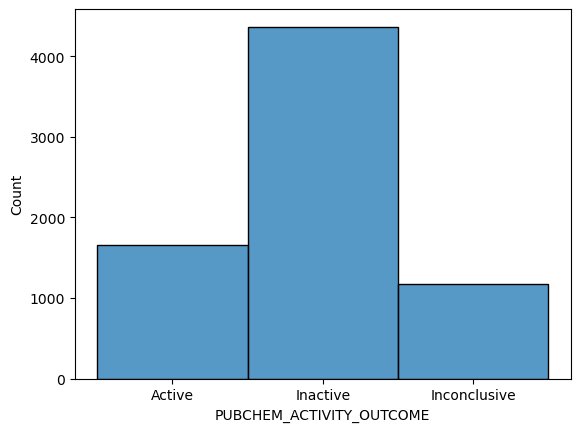

In [14]:
sns.histplot(data=full_df, x='PUBCHEM_ACTIVITY_OUTCOME')

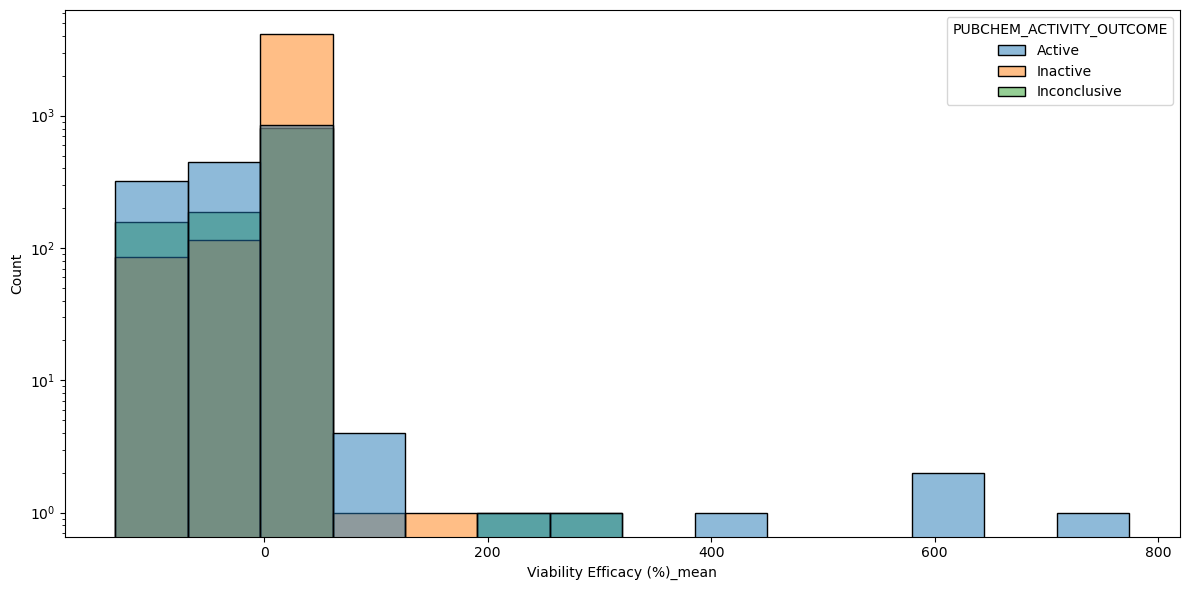

In [15]:
plt.figure(figsize=(12, 6))  # width=12 inches, height=6 inches
sns.histplot(data=full_df, x='Viability Efficacy (%)_mean', hue='PUBCHEM_ACTIVITY_OUTCOME')
plt.yscale('log')
plt.tight_layout()
plt.show()

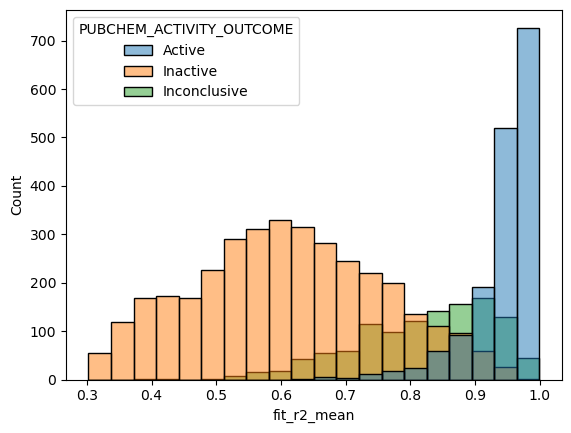

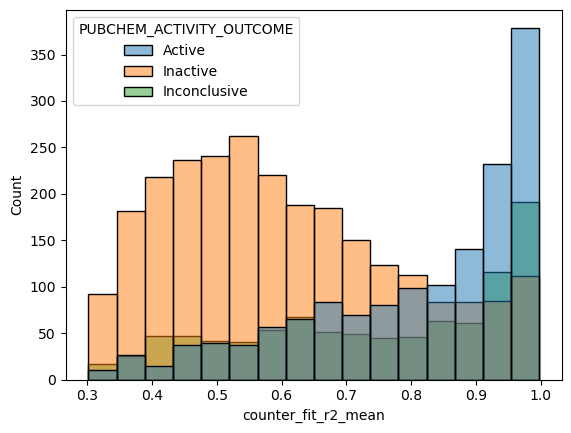

In [16]:
cols = [x for x in full_df.columns if 'r2_mean' in x]
for i in cols:
    sns.histplot(data=full_df, x=i, hue='PUBCHEM_ACTIVITY_OUTCOME')
    plt.show()

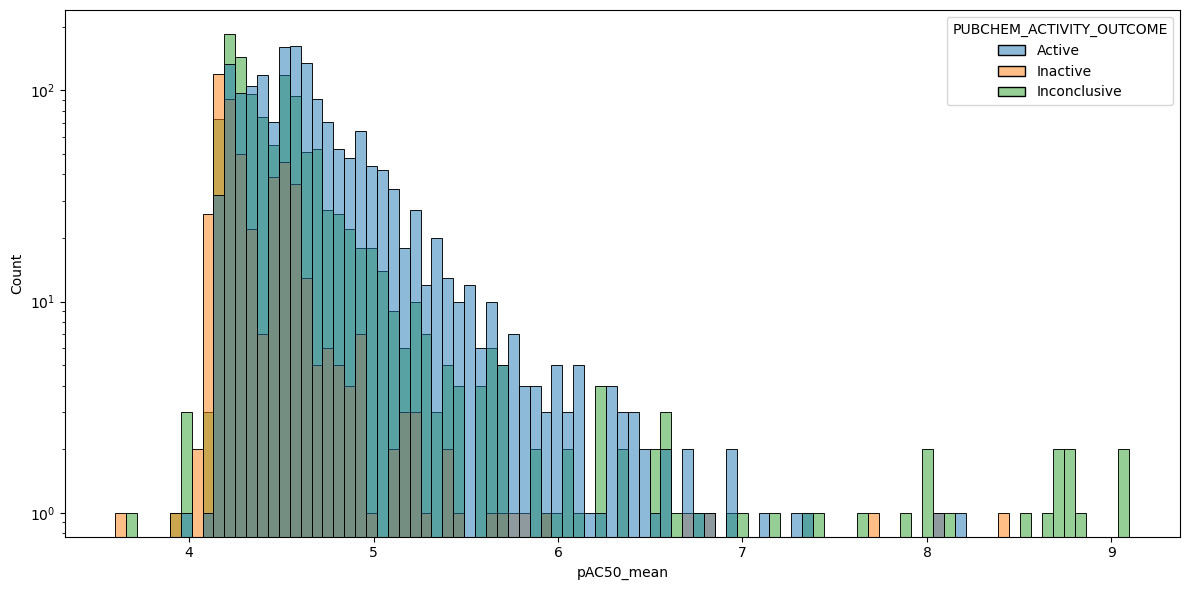

In [17]:
plt.figure(figsize=(12, 6))  # width=12 inches, height=6 inches
sns.histplot(data=full_df, x= 'pAC50_mean', hue='PUBCHEM_ACTIVITY_OUTCOME')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [18]:
## this is the revisions
# from pydantic import BaseModel, Field
# from typing import Optional
# from rdkit import Chem

# from openadmet.toolkit.chemoinformatics.rdkit_funcs import canonical_smiles, smiles_to_inchikey

# class CSVProcessing(BaseModel):
#     """
#     Class to handle processing data from a csv downloaded

#     """
#     smiles_col: Optional[str] = None

#     @staticmethod
#     def read_csv(csv_path, sep=","):
#         """
#         Wrapper for inbuilt pandas read_csv()
#         """
#         return pd.read_csv(csv_path, sep=sep)

#     def standardize_smiles_and_convert(self, data):
#         """
#         Converts data to canonical smiles and determines inchikey

#         Parameters
#         ----------
#         data : DataFrame
#             Dataframe of csv of downloaded compound data

#         Returns
#         -------
#         data : DataFrame
#             Dataframe with smiles canonicalized and inchikey
#             column added
#         """

#         if self.smiles_col:
#             if self.smiles_col not in data.columns:
#                 raise ValueError("The provided column is not in the data table!")
#             else:
#                 data["CANONICAL_SMILES"] = data[self.smiles_col].apply(lambda x: canonical_smiles(x))
#                 data["INCHIKEY"] = data["CANONICAL_SMILES"].apply(
#                     lambda x: smiles_to_inchikey(x)
#                 )
#         else:
#             # Get column with SMILES string
#             cols = [col for col in data.columns if 'smiles' in col.lower()]

#             if len(cols) == 1:
#                 col = cols[0]
#                 data["CANONICAL_SMILES"] = data[col].apply(lambda x: canonical_smiles(x))
#                 data["INCHIKEY"] = data["CANONICAL_SMILES"].apply(
#                     lambda x: smiles_to_inchikey(x)
#                 )
                
#             else:
#                 raise ValueError("Multiple columns with SMILES strings detected! Choose one for CANONICAL_SMILES.")

#         data.dropna(subset="INCHIKEY", inplace=True)
#         return data